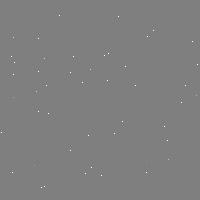

In [12]:
#导入模拟仿真需要的库
import tensorflow as tf
import numpy as np

#导入可视化需要的库
import PIL.Image
from io import StringIO,BytesIO
from IPython.display import clear_output, Image, display


def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  '''Display an array as a picture.'''
  #print(a)
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  #print(a)
  a = np.uint8(np.clip(a, 0, 255))
  #print(a)
  #b =  np.asarray(a)
  #print(b.shape)
  #print(list(b.shape))
  #print(list(b.shape)+[1,1])
#  f = StringIO()
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
#  image_path = "C:/Users/Madhouse/O38y-haichqz4883262.jpg"
#  display(Image(filename =  image_path ))
  display(Image(data=f.getvalue()))

N = 200
# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype="float32")
ut_init = np.zeros([N, N], dtype="float32")

# Some rain drops hit a pond at random points
for n in range(50):
  a,b = np.random.randint(0, N, 2)
  #print("a=%d,b=%d"%(a,b))
  u_init[a,b] = np.random.uniform()
  #print("unit[%d,%d]=%f"%(a,b,u_init[a,b]))

DisplayArray(u_init, rng=[-0.2, 0.2])

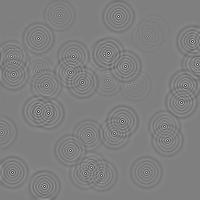

In [15]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  print(a.shape)
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  print(x.shape)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  print(y.shape)
  print((y[0, :, :, 0]).shape)
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(U.assign(U_),Ut.assign(Ut_))

sess = tf.InteractiveSession()
# Initialize state to initial conditions
tf.initialize_all_variables().run()

# Run 1000 steps of PDE
for i in range(500):
  # Step simulation
  step.run({eps: 0.03, damping: 0.04})
  # Visualize every 50 steps
  if i % 50 == 0:
    clear_output()
    DisplayArray(U.eval(), rng=[-0.2, 0.2])